## Dataset



Bitcoin is a digital currency created in January 2009. It follows the ideas set out in a whitepaper by the mysterious and pseudonymous Satoshi Nakamoto. The identity of the person or persons who created the technology is still a mystery. Bitcoin offers the promise of lower transaction fees than traditional online payment mechanisms and, unlike government-issued currencies, it is operated by a decentralized authority.

Data Description
This dataset provides the history of daily prices of Bitcoin. The data starts from 17-Sep-2014 and is updated till 09-July-2021. All the column descriptions are provided below.

* Date: Day/Month/Year
* Open: Price from the first transaction of a trading day
* High: Maximum price in a trading day
* Low: Minimum price in a trading day
* Close: Price from the last transaction of a trading day
* Adj Close: Closing price adjusted to reflect the value after accounting for any corporate actions
* Volume: Number of units traded in a day

In [ ]:
#@title Download Dataset
#!wget -qq !wget -qq https:// (load your dataset)
print("Dataset downloaded successfully!!")

Dataset downloaded successfully!!


### Import required Packages

In [ ]:
!pip install -q mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.1 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_predict
import statsmodels.api as sm
import itertools
import mplfinance as mpf

### Load the data and perform EDA


In [ ]:
btc_df = pd.read_csv('BTC.csv', index_col='Date', parse_dates=True)
btc_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


In [ ]:
btc_df.shape

(2520, 6)

In [ ]:
btc_df.isnull().sum()

,0
Open,4
High,4
Low,4
Close,4
Adj Close,4
Volume,4


In [ ]:
btc_df.dropna(inplace=True)
print(btc_df.shape)

(2516, 6)


In [ ]:
btc_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03
mean,8367.993124,8609.046940,8104.681274,8384.849217,8384.849217,1.314307e+10
std,12379.802902,12769.294273,11929.803665,12399.075891,12399.075891,1.979067e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,569.089508,575.391754,561.964737,569.758758,569.758758,7.095970e+07
50%,4947.056884,5115.198242,4829.396973,4971.905029,4971.905029,4.249775e+09
75%,9386.981445,9557.482911,9238.094238,9393.408692,9393.408692,2.026569e+10
max,63523.753906,64863.097656,62208.964844,63503.457031,63503.457031,3.509679e+11


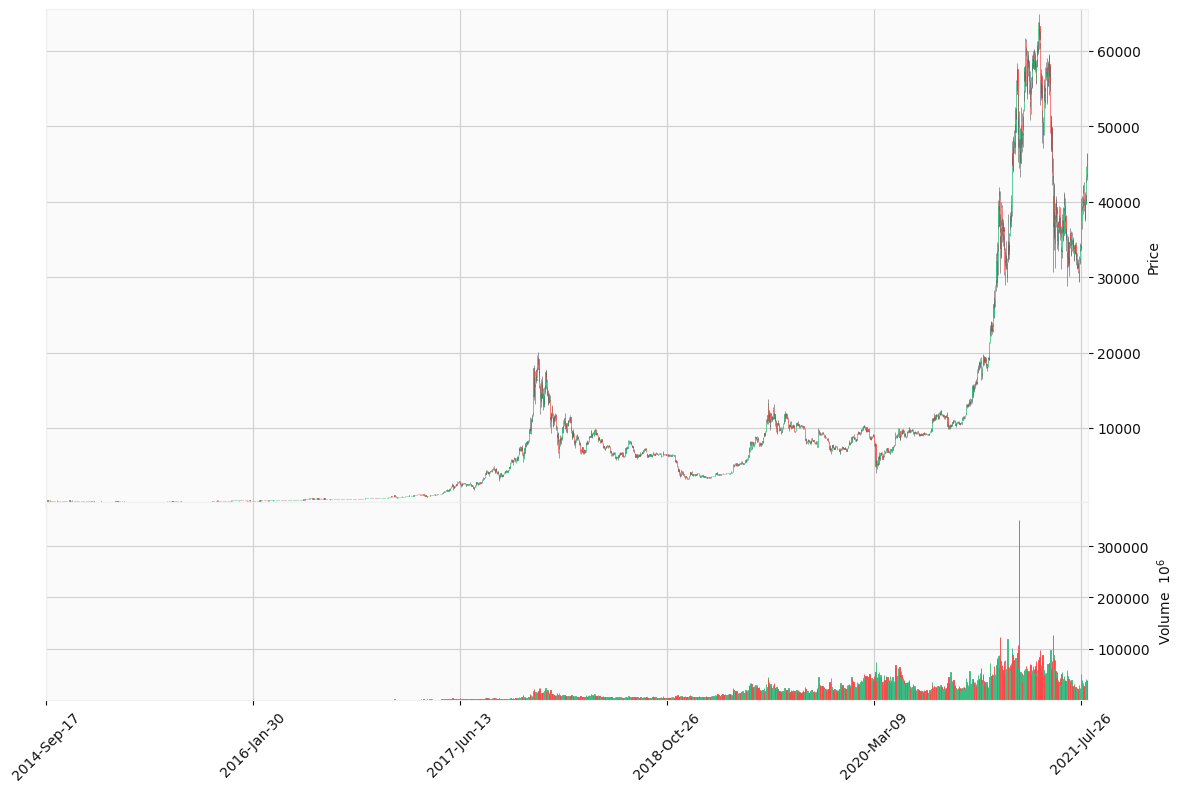

In [ ]:
# plotting ohlc and volume data using mplfinance
kws=dict(volume=True,tight_layout=True, style='yahoo', type='candle', figsize=(12,8))
mpf.plot(btc_df,**kws)

In [ ]:
rs_df = btc_df.resample('w').mean()
rs_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-21,429.916998,437.718194,406.624402,416.859003,416.859003,3.138068e+07
2014-09-28,410.650718,418.668993,399.377141,407.692566,407.692566,2.668180e+07
2014-10-05,369.774288,376.721000,353.207140,361.426570,361.426570,3.952256e+07
2014-10-12,346.927429,363.308864,337.567858,355.234580,355.234580,4.873611e+07
2014-10-19,389.010284,397.790427,380.410575,390.479854,390.479854,2.241458e+07


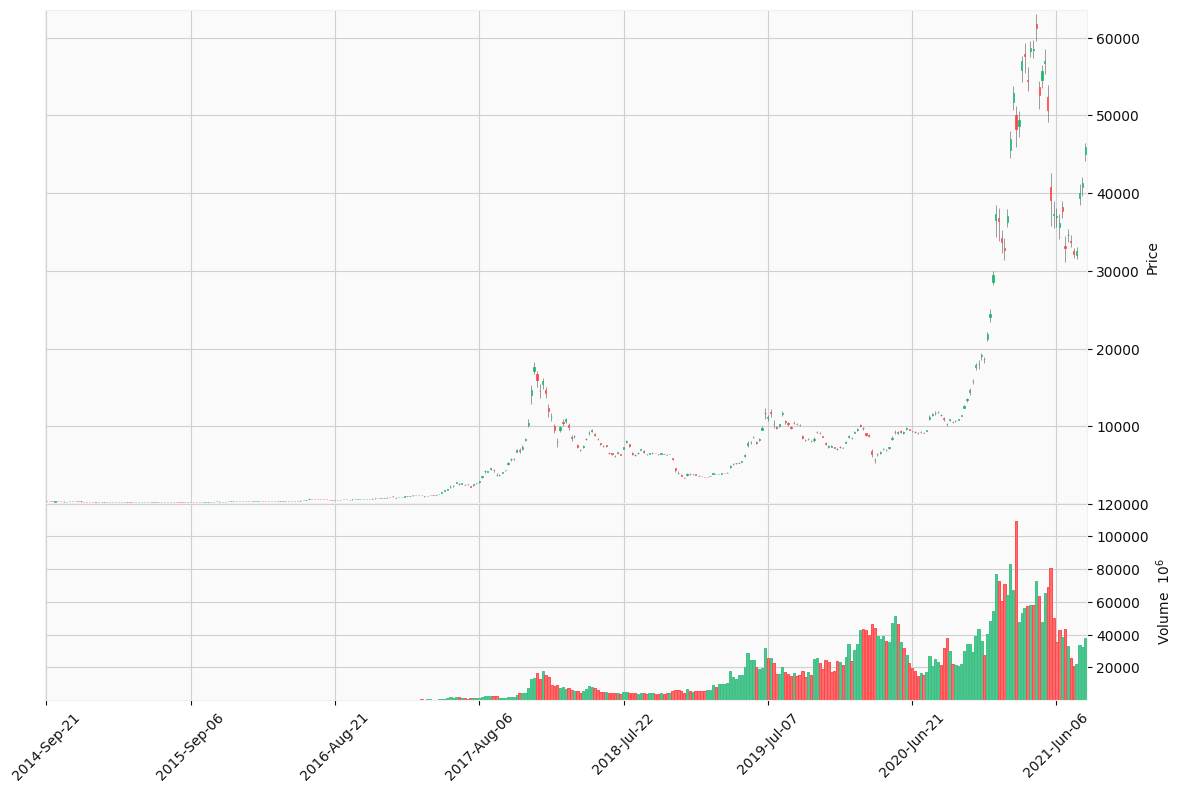

In [ ]:
mpf.plot(rs_df,**kws)

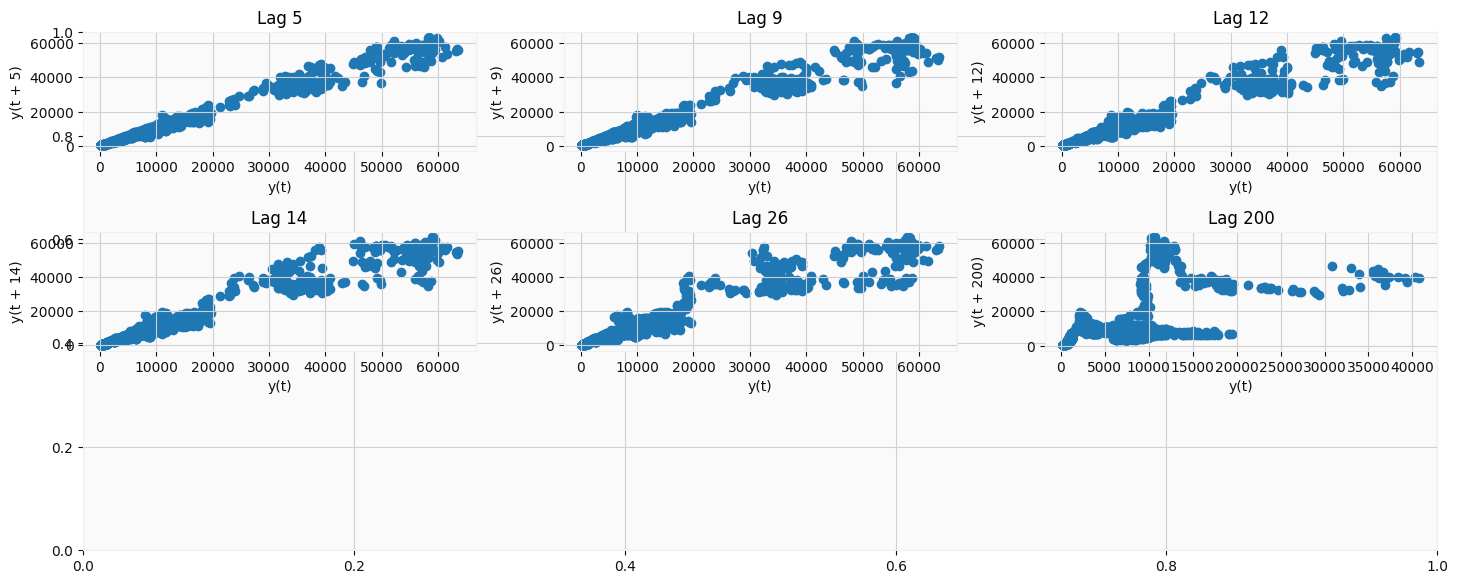

In [ ]:
periods = [5,9,12,14,26,200]
plt.subplots(figsize=(15,6))
for i,t in enumerate(periods):
    plt.subplot(len(periods)//2,3,i+1)
    pd.plotting.lag_plot(btc_df['Close'], lag=t)
    plt.title('Lag '+str(periods[i]))
    plt.tight_layout()

plt.show()

### Feature engineering
Bollinger bands, MACD and Stachastic momentum are important features for the analysis

In [ ]:
# Bollinger-Band
# computes the datapoints for moving average, upper band and the lower band
# source: https://github.com/pratiknabriya/Bollinger-Bands-with-Python/blob/main/Bollinger_Bands.ipynb
def bollinger_band(df, window = 5, num_stdev = 2):
    length = window
    bb = pd.DataFrame()
    prices = df['Close']
    bb['MA'] = prices.rolling(length).mean()
    bb['stdev2'] = prices.rolling(length).std()
    bb['upband'] = bb['MA'] + num_stdev*bb['stdev2']
    bb['dwnband'] = bb['MA'] - num_stdev*bb['stdev2']
    bb['PercentB'] = (df['Close']-bb['dwnband'])/(bb['upband']-bb['dwnband'])
    return bb

bb_df = bollinger_band(btc_df)

bb_df.head(7)

,MA,stdev2,upband,dwnband,PercentB
Date,,,,,
2014-09-17,NaN,NaN,NaN,NaN,NaN
2014-09-18,NaN,NaN,NaN,NaN,NaN
2014-09-19,NaN,NaN,NaN,NaN,NaN
2014-09-20,NaN,NaN,NaN,NaN,NaN
2014-09-21,416.859003,25.353136,467.565274,366.152731,0.322133
2014-09-22,405.822601,11.620932,429.064465,382.580738,0.421035
2014-09-23,408.092798,16.324151,440.741100,375.444495,0.924190


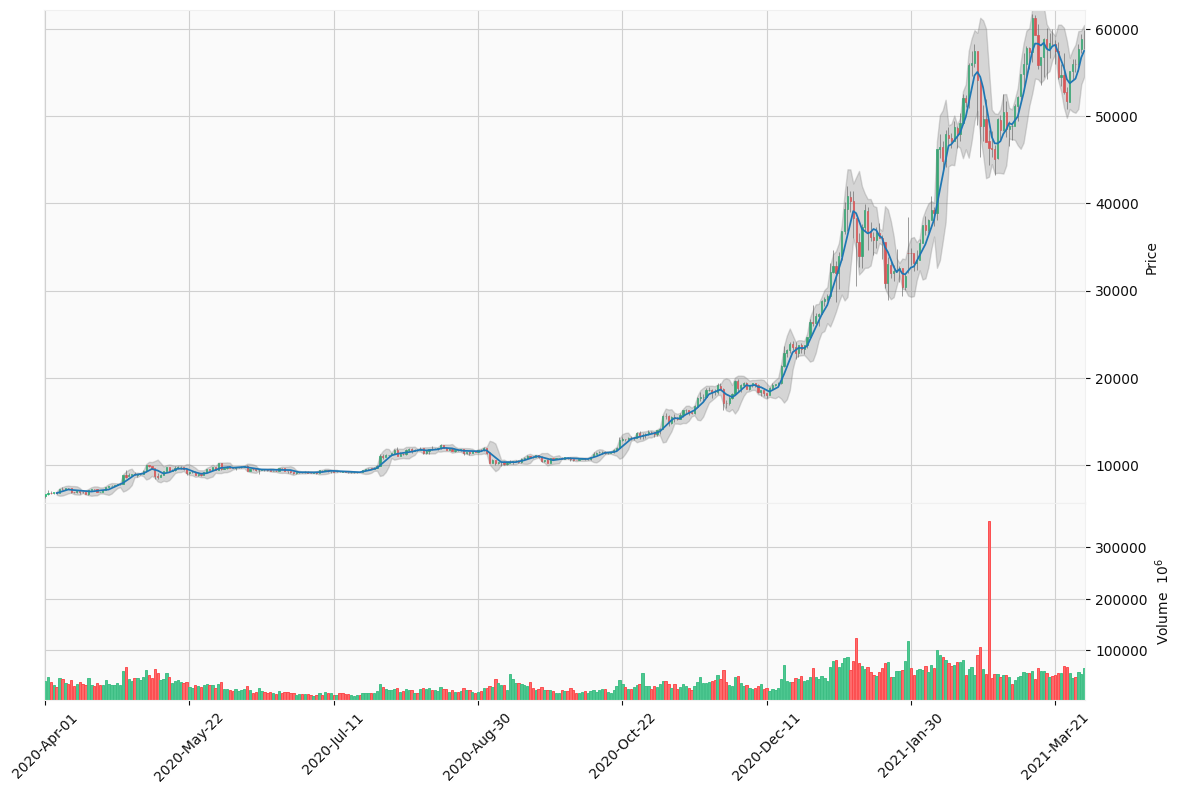

In [ ]:
fy_20_21_df = btc_df.loc['2020-04-01':'2021-03-31'].copy()
bb_df = bollinger_band(fy_20_21_df, window=5)  # DataFrame with Moving average columns
apd  = mpf.make_addplot(bb_df['MA'],
                        fill_between=dict(y1=bb_df['dwnband'].values,
                                          y2=bb_df['upband'].values,
                                          color='grey',
                                          alpha=0.3),)
mpf.plot(fy_20_21_df,**kws, addplot=apd)

In [ ]:
# Moving Average Convergence Divergence (MACD)
def MACD(df, window_slow, window_fast, window_signal):
    macd = pd.DataFrame()
    macd['ema_slow'] = df['Close'].ewm(span=window_slow).mean()
    macd['ema_fast'] = df['Close'].ewm(span=window_fast).mean()
    macd['macd'] = macd['ema_slow'] - macd['ema_fast']
    macd['signal'] = macd['macd'].ewm(span=window_signal).mean()
    macd['diff'] = macd['macd'] - macd['signal']
    macd['bar_positive'] = macd['diff'].map(lambda x: x if x > 0 else 0)
    macd['bar_negative'] = macd['diff'].map(lambda x: x if x < 0 else 0)
    return macd


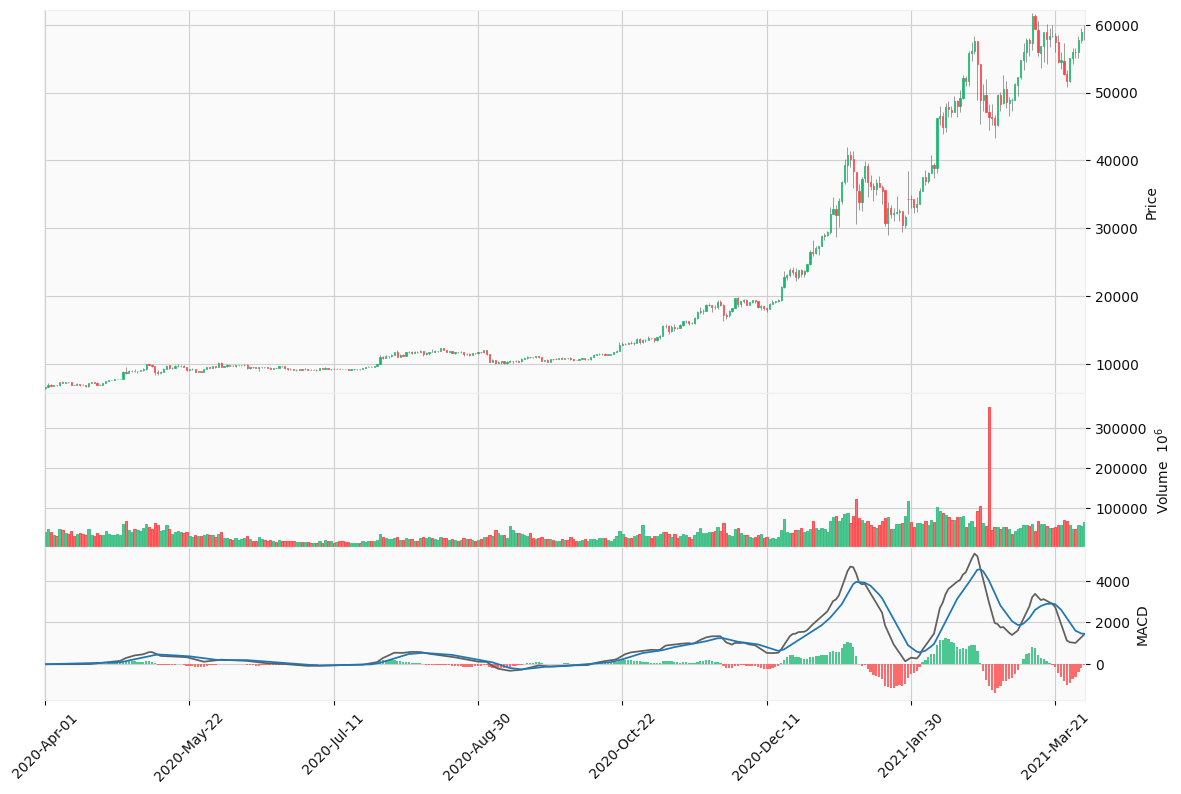

In [ ]:
macd = MACD(fy_20_21_df, 12, 26, 9)
macd_plot  = [
    mpf.make_addplot((macd['macd']), color='#606060', panel=2, ylabel='MACD', secondary_y=False),
    mpf.make_addplot((macd['signal']), color='#1f77b4', panel=2, secondary_y=False),
    mpf.make_addplot((macd['bar_positive']), type='bar', color='#4dc790', panel=2),
    mpf.make_addplot((macd['bar_negative']), type='bar', color='#fd6b6c', panel=2),
]

mpf.plot(fy_20_21_df, **kws, addplot=macd_plot)

In [ ]:
# Stochastic-Oscillator
def Stochastic(df, window, smooth_window):
    stochastic = pd.DataFrame()
    stochastic['%K'] = ((df['Close'] - df['Low'].rolling(window).min()) \
                        / (df['High'].rolling(window).max() - df['Low'].rolling(window).min())) * 100
    stochastic['%D'] = stochastic['%K'].rolling(smooth_window).mean()
    stochastic['%SD'] = stochastic['%D'].rolling(smooth_window).mean()
    stochastic['UL'] = 80
    stochastic['DL'] = 20
    return stochastic


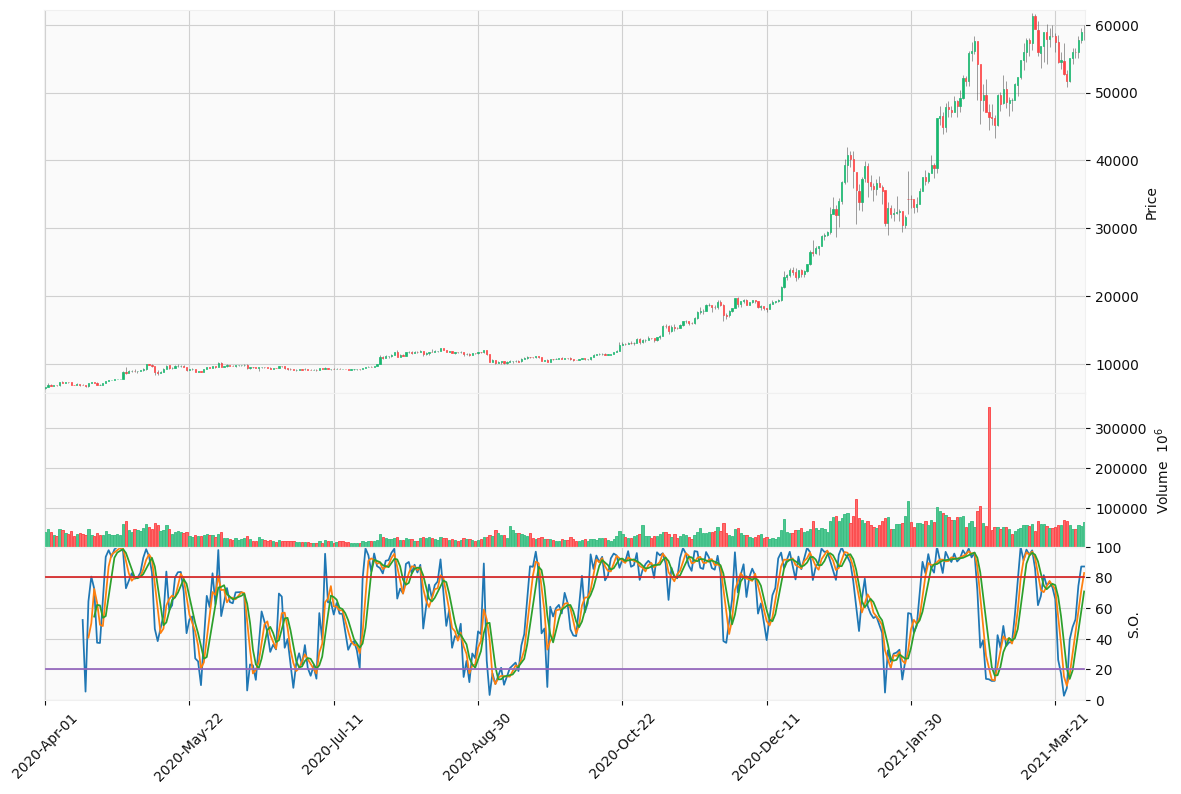

In [ ]:
stochastic = Stochastic(fy_20_21_df, 14, 3)
stochastic_plot  = [
    mpf.make_addplot((stochastic[['%K', '%D', '%SD', 'UL', 'DL']]), ylim=[0, 100], panel=2, ylabel='S.O.')
]

mpf.plot(fy_20_21_df, **kws, addplot=stochastic_plot)

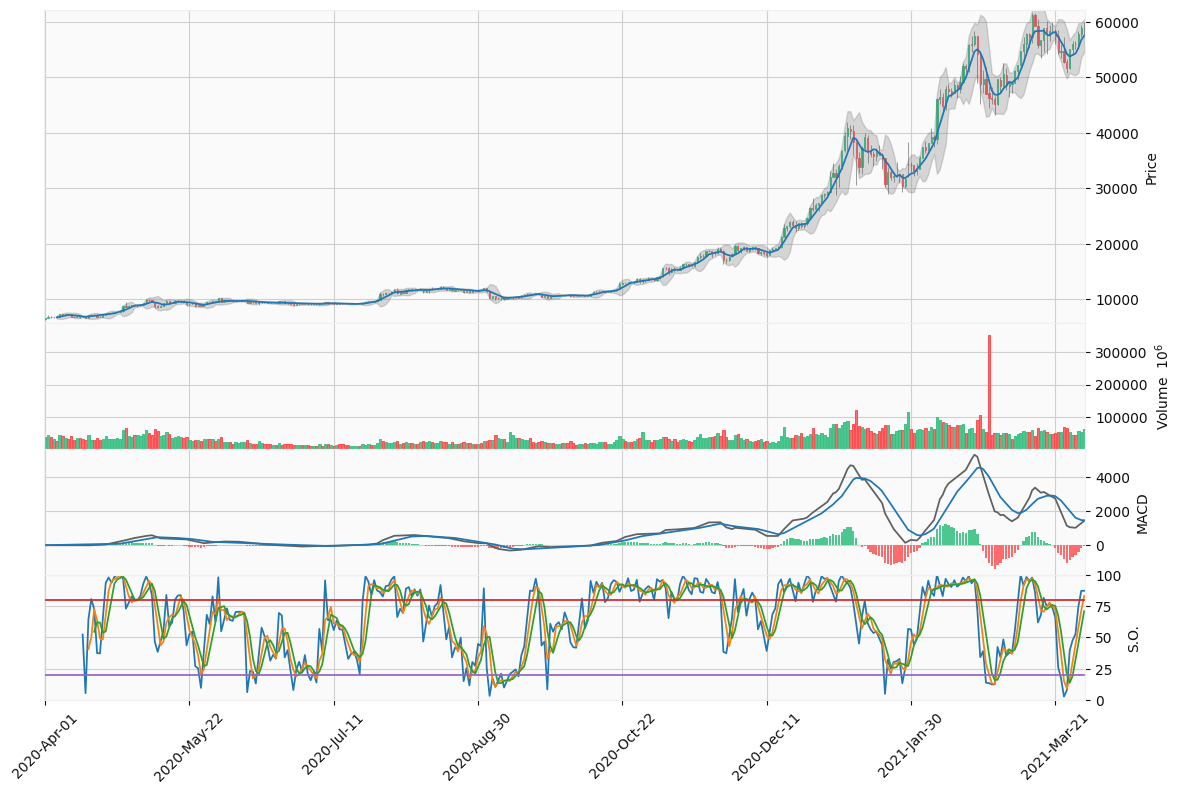

In [ ]:
# putting all together for entry and exit decisions
apd  = [mpf.make_addplot(bb_df['MA'],
                        fill_between=dict(y1=bb_df['dwnband'].values,
                                          y2=bb_df['upband'].values,
                                          color='grey',
                                          alpha=0.3),),
        mpf.make_addplot((macd['macd']), color='#606060', panel=2, ylabel='MACD', secondary_y=False),
        mpf.make_addplot((macd['signal']), color='#1f77b4', panel=2, secondary_y=False),
        mpf.make_addplot((macd['bar_positive']), type='bar', color='#4dc790', panel=2),
        mpf.make_addplot((macd['bar_negative']), type='bar', color='#fd6b6c', panel=2),
        mpf.make_addplot((stochastic[['%K', '%D', '%SD', 'UL', 'DL']]), ylim=[0, 100], panel=3, ylabel='S.O.'),
        ]
mpf.plot(fy_20_21_df,**kws, addplot=apd)

#### Analyze the correlation (heatmap) of all the features

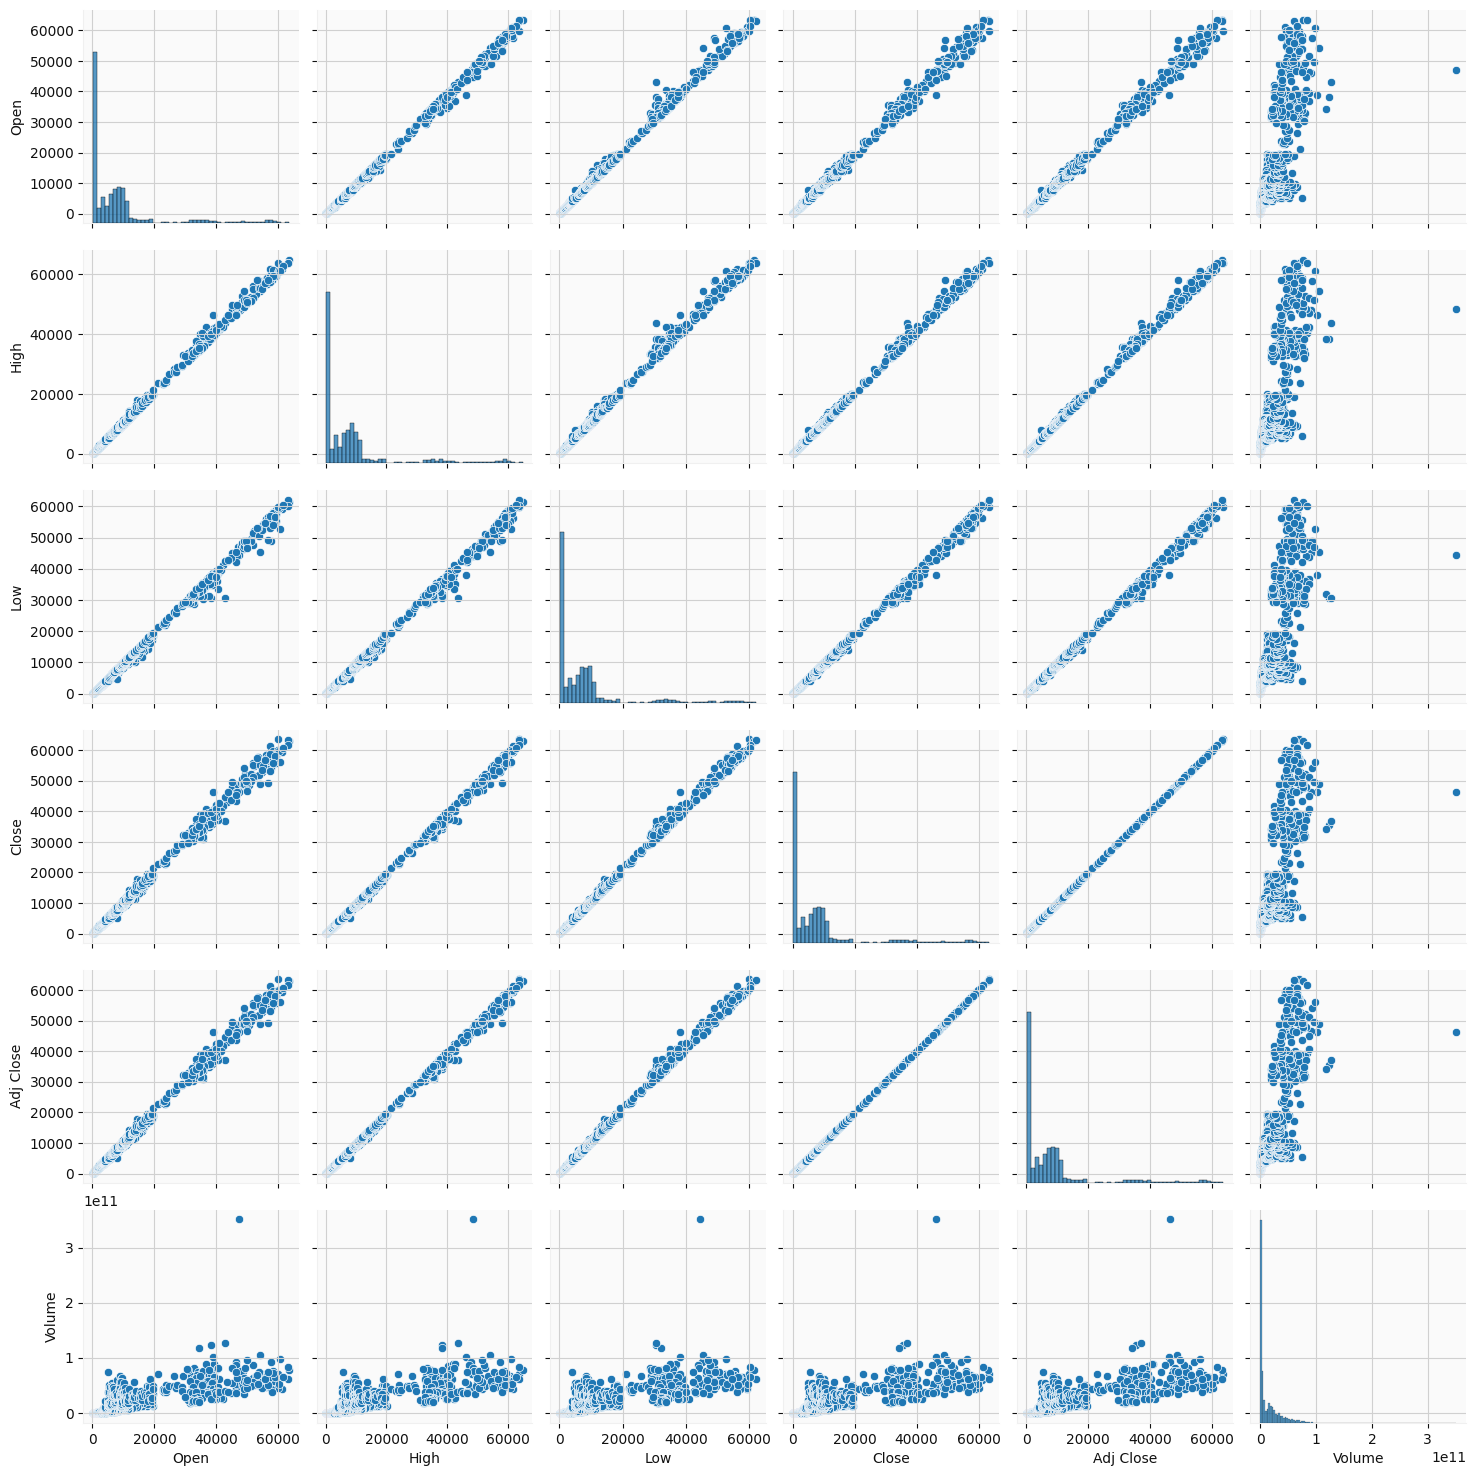

In [ ]:
g = sns.pairplot(btc_df[btc_df.columns])

In [ ]:
btc_df_2 = btc_df.copy()
bb_df_2 = bollinger_band(btc_df_2)
macd_df_2 = MACD(btc_df_2, 12, 26, 9)
so_df_2 = Stochastic(btc_df_2, 14, 3)
btc_df_2 = pd.concat([btc_df_2, bb_df_2, macd_df_2, so_df_2], axis=1)

In [ ]:
btc_df_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2014-09-17 to 2021-08-10
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2516 non-null   float64
 1   High          2516 non-null   float64
 2   Low           2516 non-null   float64
 3   Close         2516 non-null   float64
 4   Adj Close     2516 non-null   float64
 5   Volume        2516 non-null   float64
 6   MA            2512 non-null   float64
 7   stdev2        2512 non-null   float64
 8   upband        2512 non-null   float64
 9   dwnband       2512 non-null   float64
 10  PercentB      2512 non-null   float64
 11  ema_slow      2516 non-null   float64
 12  ema_fast      2516 non-null   float64
 13  macd          2516 non-null   float64
 14  signal        2516 non-null   float64
 15  diff          2516 non-null   float64
 16  bar_positive  2516 non-null   float64
 17  bar_negative  2516 non-null   float64
 18  %K        

In [ ]:
btc_df_2 = btc_df_2.drop(columns=['UL','DL'])

In [ ]:
btc_pear_corr= btc_df_2[btc_df_2.columns].corr(method='pearson')
btc_pear_corr

,Open,High,Low,Close,Adj Close,Volume,MA,stdev2,upband,dwnband,...,ema_slow,ema_fast,macd,signal,diff,bar_positive,bar_negative,%K,%D,%SD
Open,1.000000,0.999412,0.998898,0.998607,0.998607,0.791723,0.999182,0.847751,0.998120,0.997814,...,0.997285,0.991892,0.283306,0.297068,0.008252,0.520834,-0.444413,0.050847,0.061719,0.065800
High,0.999412,1.000000,0.998812,0.999398,0.999398,0.794166,0.999008,0.853900,0.998487,0.997009,...,0.997161,0.991715,0.284070,0.297441,0.009740,0.526146,-0.446983,0.055476,0.063251,0.066306
Low,0.998898,0.998812,1.000000,0.999258,0.999258,0.785406,0.998155,0.837885,0.996323,0.997692,...,0.995983,0.990343,0.286742,0.297351,0.019724,0.523737,-0.430921,0.060255,0.067081,0.068958
Close,0.998607,0.999398,0.999258,1.000000,1.000000,0.790311,0.998336,0.846861,0.997260,0.996987,...,0.996210,0.990484,0.288074,0.299001,0.018895,0.529245,-0.436901,0.063582,0.067419,0.068704
Adj Close,0.998607,0.999398,0.999258,1.000000,1.000000,0.790311,0.998336,0.846861,0.997260,0.996987,...,0.996210,0.990484,0.288074,0.299001,0.018895,0.529245,-0.436901,0.063582,0.067419,0.068704
Volume,0.791723,0.794166,0.785406,0.790311,0.790311,1.000000,0.792810,0.742642,0.797970,0.784700,...,0.790578,0.781555,0.295545,0.326182,-0.047151,0.428473,-0.440986,0.053723,0.065509,0.074003
MA,0.999182,0.999008,0.998155,0.998336,0.998336,0.792810,1.000000,0.848845,0.998971,0.998591,...,0.998749,0.993967,0.274398,0.292958,-0.009917,0.507113,-0.457778,0.041609,0.051141,0.057734
stdev2,0.847751,0.853900,0.837885,0.846861,0.846861,0.742642,0.848845,1.000000,0.871943,0.819598,...,0.848542,0.843784,0.243504,0.267007,-0.032887,0.547093,-0.524878,0.016269,0.027006,0.037116
upband,0.998120,0.998487,0.996323,0.997260,0.997260,0.797970,0.998971,0.871943,1.000000,0.995158,...,0.997787,0.992950,0.275024,0.294229,-0.012006,0.516596,-0.468998,0.039933,0.049682,0.056655
dwnband,0.997814,0.997009,0.997692,0.996987,0.996987,0.784700,0.998591,0.819598,0.995158,1.000000,...,0.997266,0.992561,0.272950,0.290705,-0.007447,0.494692,-0.443452,0.043463,0.052715,0.058845


<Axes: >

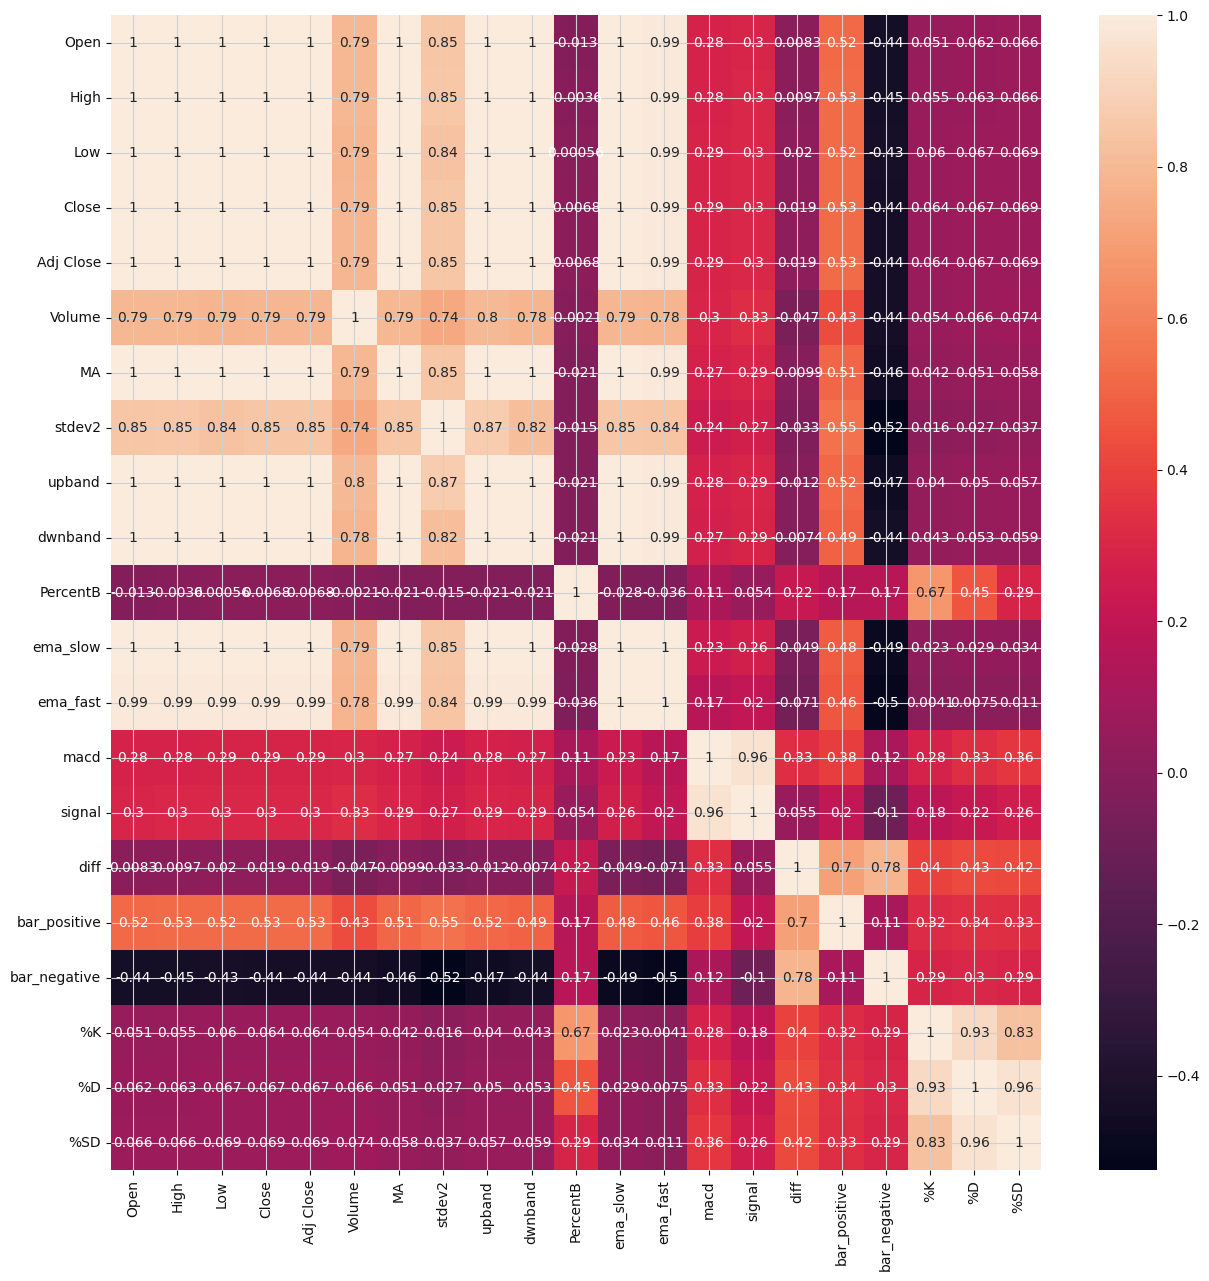

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(btc_pear_corr,annot=True)

### Feature Importance
Using RandomForestRegressor for identifying feature importance

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

In [ ]:
feat_df = btc_df_2.copy()
feat_df.fillna(0,inplace=True)
# scale the feat_df
scaler = StandardScaler()
feat_df = pd.DataFrame(scaler.fit_transform(feat_df), columns=feat_df.columns)

In [ ]:
feat_df.head()

,Open,High,Low,Close,Adj Close,Volume,MA,stdev2,upband,dwnband,...,ema_slow,ema_fast,macd,signal,diff,bar_positive,bar_negative,%K,%D,%SD
0,-0.638435,-0.637662,-0.641568,-0.639490,-0.639490,-0.663172,-0.676451,-0.538864,-0.672721,-0.679051,...,-0.640019,-0.640200,-0.127375,-0.130278,-0.014959,-0.361211,0.295303,-1.8571,-1.966609,-2.013876
1,-0.639163,-0.638548,-0.644864,-0.642144,-0.642144,-0.662493,-0.676451,-0.538864,-0.672721,-0.679051,...,-0.641474,-0.641614,-0.128288,-0.130814,-0.016429,-0.361211,0.293249,-1.8571,-1.966609,-2.013876
2,-0.641809,-0.640821,-0.647260,-0.644535,-0.644535,-0.662320,-0.676451,-0.538864,-0.672721,-0.679051,...,-0.642900,-0.642966,-0.129676,-0.131591,-0.018791,-0.361211,0.289947,-1.8571,-1.966609,-2.013876
3,-0.644187,-0.641177,-0.646811,-0.643397,-0.643397,-0.662373,-0.676451,-0.538864,-0.672721,-0.679051,...,-0.643239,-0.643314,-0.129620,-0.131950,-0.017361,-0.361211,0.291947,-1.8571,-1.966609,-2.013876
4,-0.643103,-0.642028,-0.646535,-0.644211,-0.644211,-0.662893,-0.642675,-0.494496,-0.637633,-0.646897,...,-0.643662,-0.643715,-0.130040,-0.132291,-0.017712,-0.361211,0.291456,-1.8571,-1.966609,-2.013876


In [ ]:
X, y = feat_df.drop(columns=['Close']), feat_df['Close']

In [ ]:
clf = RandomForestRegressor(n_estimators=100, random_state=42)
clf.fit(X, y)

importance = clf.feature_importances_

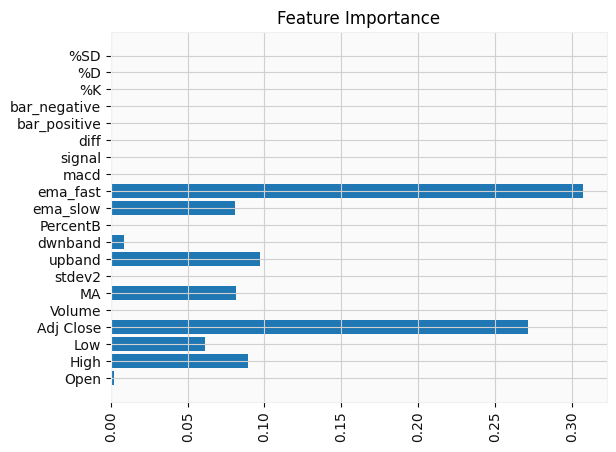

In [ ]:
plt.barh(X.columns,importance)
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.show()

<Axes: >

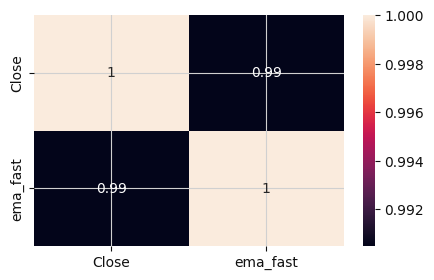

In [ ]:
features=['Close','ema_fast']
plt.figure(figsize=(5,3))
sns.heatmap(btc_df_2[features].corr(),annot=True)

As there are two important features that could predict the closing price
- Closing Price historical data
- Exponential moving average of the btc dataset.

we could use two separate models to predict the prices and compare it.

### Test the Stationarity using Augmented Dicky Fuller Test

The Augmented Dicky Fuller test is a type of statistical test called a unit root test.


In [ ]:
ts1 = btc_df['Close'].copy()
ts1.fillna(0, inplace=True)

In [ ]:
#Perform Dickey Fuller test
def test_stationarity(timeseries):
    print('alpha = 0.05')
    print('Results of Dickey Fuller Test:')
    result = adfuller(timeseries)
    print('ADF Stastistic: %f'%result[0])
    print('p-value: %f'%result[1])
    pvalue = result[1]
    for key,value in result[4].items():
        if result[0]>value:
            print("The graph is non stationery")
            break
        else:
            print("The graph is stationary")
            break;
        print('Critical values:')
    for key,value in result[4].items():
            print('\t%s: %.3f ' % (key, value))
    print('-----End of Test-----')

In [ ]:
test_stationarity(ts1)

alpha = 0.05
Results of Dickey Fuller Test:
ADF Stastistic: -0.038593
p-value: 0.955222
The graph is non stationery
	1%: -3.433 
	5%: -2.863 
	10%: -2.567 
-----End of Test-----


### Identify the trends and seasonality from the given time series data

* Apply seasonal decompose and plot the results
* Check the stationarity of data using rolling mean and rolling standard deviation.
* Make the time series data stationary
  * Apply a log transformation to reduce the variance of the series
  * Eliminate the Trend and Seasonality by Differencing


In [ ]:
ts1 = btc_df['Close'].copy()

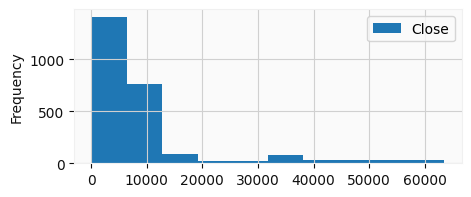

In [ ]:
plt.figure(figsize=(5,2))
ts1.plot(kind='hist')
plt.legend(loc='best')
plt.show()

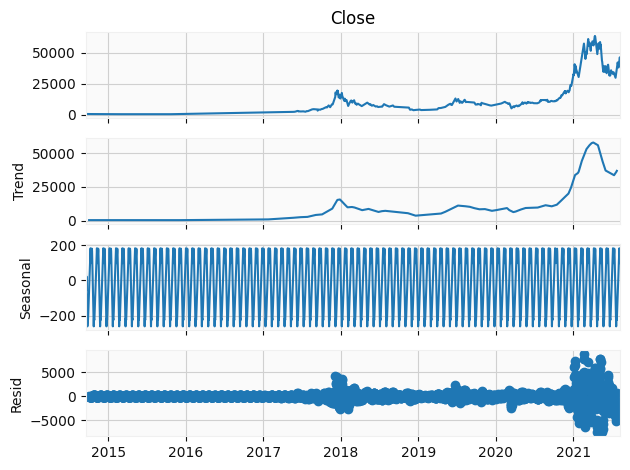

In [ ]:
# ETS Decomposition
decompose_monthly = seasonal_decompose(ts1, model='additive', period=30)
# ETS plot
decompose_monthly.plot()
plt.show()

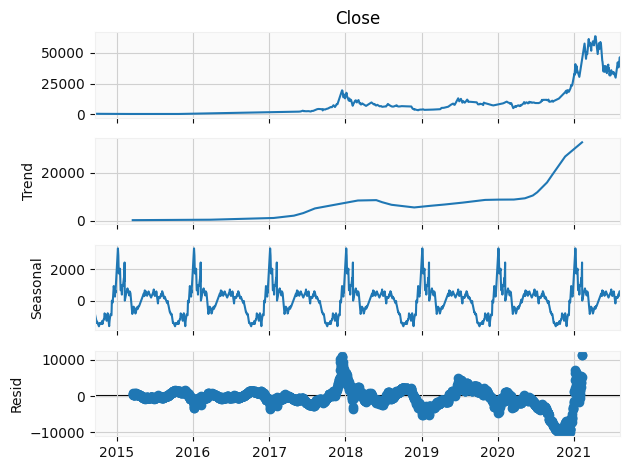

In [ ]:
# ETS Decomposition
decompose_yearly = seasonal_decompose(ts1, model='additive', period=365)
# ETS plot
decompose_yearly.plot()
plt.show()

In [ ]:
logts1 = ts1.apply(lambda x: np.log(x))
logts1.fillna(0, inplace=True)
logts1.head()

,Close
Date,
2014-09-17,6.125414
2014-09-18,6.050771
2014-09-19,5.978369
2014-09-20,6.013480
2014-09-21,5.988513


In [ ]:
logts1.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 2516 entries, 2014-09-17 to 2021-08-10
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
2516 non-null   float64
dtypes: float64(1)
memory usage: 103.9 KB


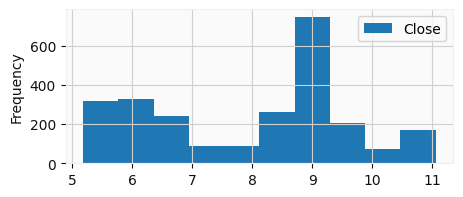

In [ ]:
plt.figure(figsize=(5,2))
logts1.plot(kind='hist')
plt.legend(loc='best')
plt.show()

In [ ]:
rolling_mean = logts1.rolling(window=365).mean()
rolling_std = logts1.rolling(window=365).std()

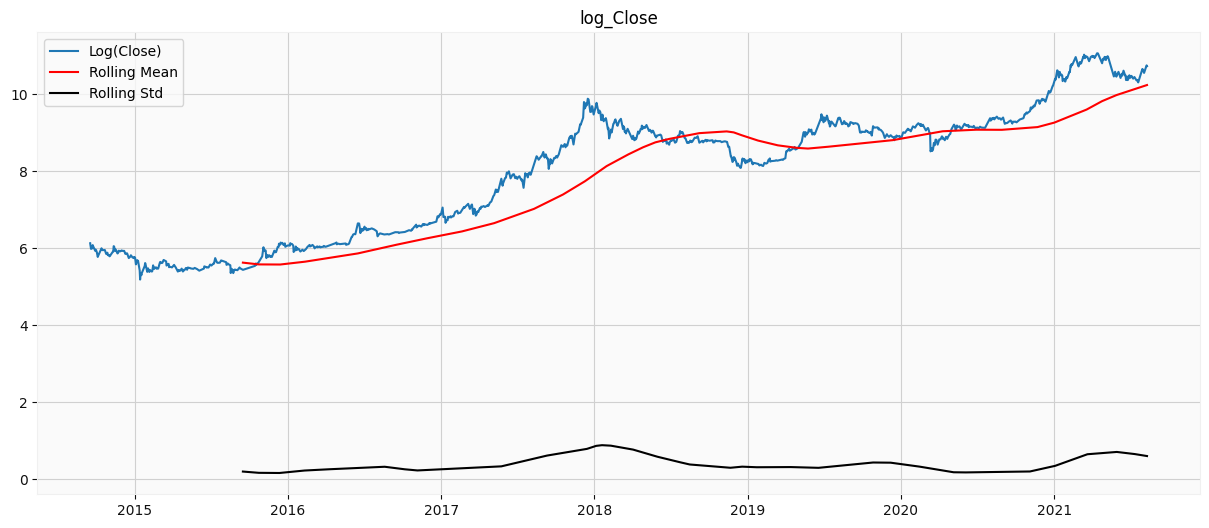

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(logts1, label='Log(Close)')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('log_Close')
plt.show()

The plot suggests the `logts1` is non-stationary.

In [ ]:
# Performing ADF test
test_stationarity(logts1)

alpha = 0.05
Results of Dickey Fuller Test:
ADF Stastistic: -0.123278
p-value: 0.947070
The graph is non stationery
	1%: -3.433 
	5%: -2.863 
	10%: -2.567 
-----End of Test-----


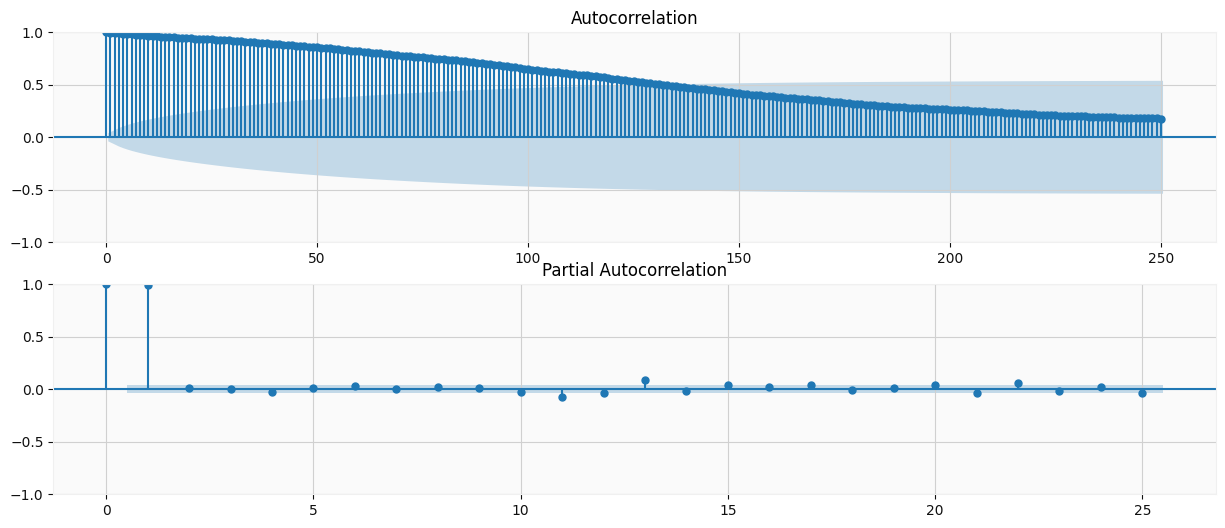

In [ ]:
# performing ACF and PACF
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,6))
plot_acf(ts1, lags=250, ax= ax[0])
plot_pacf(ts1, lags=25, ax= ax[1])
plt.show()

Observations from ACF and PACF of `ts1`

|graph|comments|
|-----|--------|
|ACF|Lags upto `t+140` is significant in prediction of the price|
|PACF|`t+1` lag has direct significance|

In [ ]:
# detrending by differencing
ts1_diff = ts1 - ts1.shift(1)
ts1_diff.fillna(0, inplace=True)
ts1_diff.head()

,Close
Date,
2014-09-17,0.000000
2014-09-18,-32.894013
2014-09-19,-29.644012
2014-09-20,14.108002
2014-09-21,-10.082978


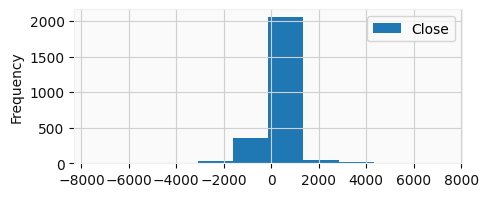

In [ ]:
plt.figure(figsize=(5,2))
ts1_diff.plot(kind='hist')
plt.legend(loc='best')
plt.show()

In [ ]:
rolling_mean = ts1_diff.rolling(window=14).mean()
rolling_std = ts1_diff.rolling(window=14).std()

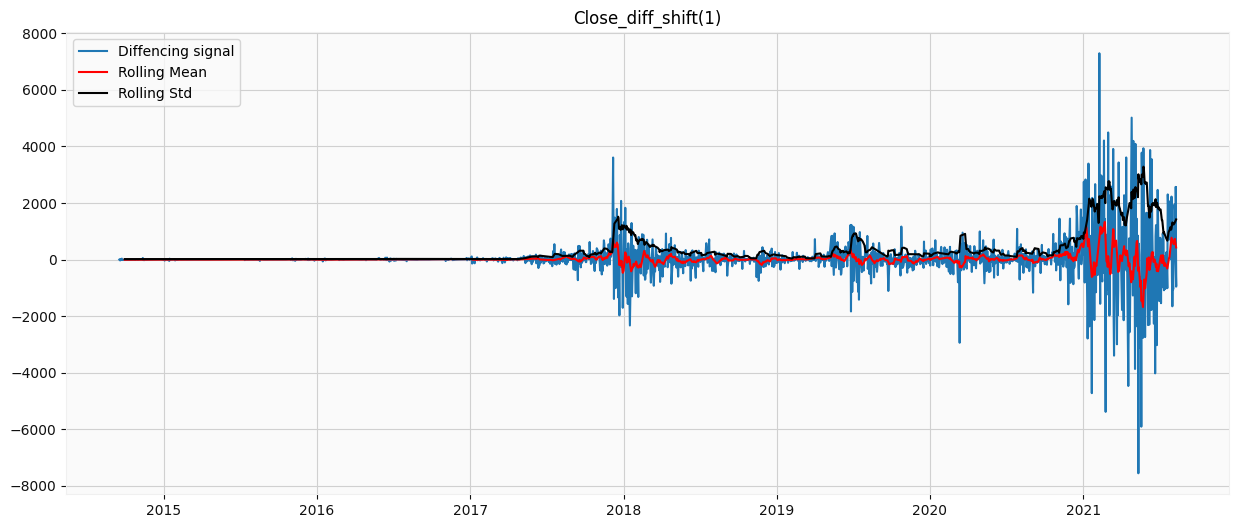

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(ts1_diff, label='Diffencing signal')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Close_diff_shift(1)')
plt.show()

The plot suggests `ts1_diff` is stationary. Although it is not conclusive!

### Test the Stationarity using Augmented Dicky Fuller Test

Verify the stationarity post differencing, using ADF


In [ ]:
test_stationarity(ts1_diff)

alpha = 0.05
Results of Dickey Fuller Test:
ADF Stastistic: -7.530927
p-value: 0.000000
The graph is stationary
	1%: -3.433 
	5%: -2.863 
	10%: -2.567 
-----End of Test-----


### Auto Correlation Plot

Autocorrelation refers to the degree of correlation between the values of the same variables across different observations in the data.  The concept of autocorrelation is most often discussed in the context of time series data in which observations occur at different points in time.

* Plot the auto correlation function (ACF and PACF)
* Analyse ACF and PACF plots and define AR (p) and MA(q) terms

In [ ]:
# ACF and PACF plots

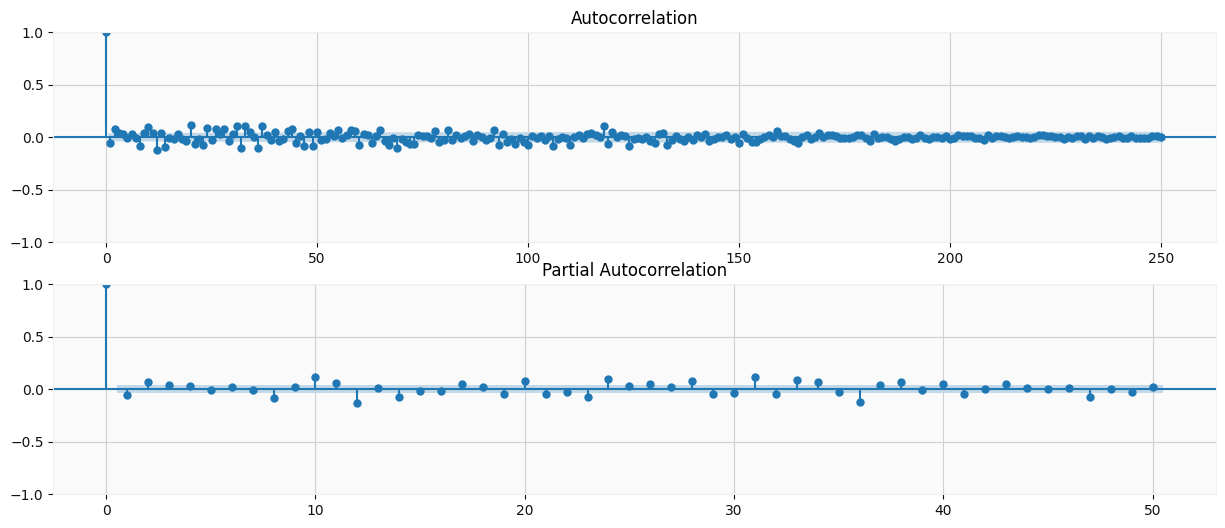

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,6))
plot_acf(ts1_diff, lags=250, ax= ax[0])
plot_pacf(ts1_diff, lags=50, ax= ax[1])
plt.show()

Based on the above plots for estimation using `['Close']` price:

|model|value|
|-----|-----|
|AR(p)|12|
|MA(q)|1|

### Train the Auto Regressive model

In [ ]:
# Train test split
train_data = ts1_diff[:'2019']
test_data = ts1_diff['2020':'2020']
train_start = train_data.index.min()
train_end = train_data.index.max()
test_start = test_data.index.min()
test_end = test_data.index.max()

In [ ]:
print(train_start,train_end)
print(test_start,test_end)

2014-09-17 00:00:00 2019-12-31 00:00:00
2020-01-01 00:00:00 2020-12-31 00:00:00


In [ ]:
train_data.tail()

,Close
Date,
2019-12-27,51.121582
2019-12-28,27.901855
2019-12-29,104.662598
2019-12-30,-129.657715
2019-12-31,-99.395996


In [ ]:
test_data.head()

,Close
Date,
2020-01-01,6.575195
2020-01-02,-214.704101
2020-01-03,359.414062
2020-01-04,65.772461
2020-01-05,0.660645


In [ ]:
ar_model0 = sm.tsa.AutoReg(train_data,lags=0)
ar_model0_fit = ar_model0.fit()
print(ar_model0_fit.summary())
print(ar_model0_fit.params)

                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                 1932
Model:                     AutoReg(0)   Log Likelihood              -13618.821
Method:               Conditional MLE   S.D. of innovations            278.701
Date:                Tue, 18 Feb 2025   AIC                          27241.642
Time:                        11:46:37   BIC                          27252.774
Sample:                    09-17-2014   HQIC                         27245.737
                         - 12-31-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4867      6.341      0.550      0.582      -8.941      15.914
const    3.48668
dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<Figure size 1500x300 with 0 Axes>

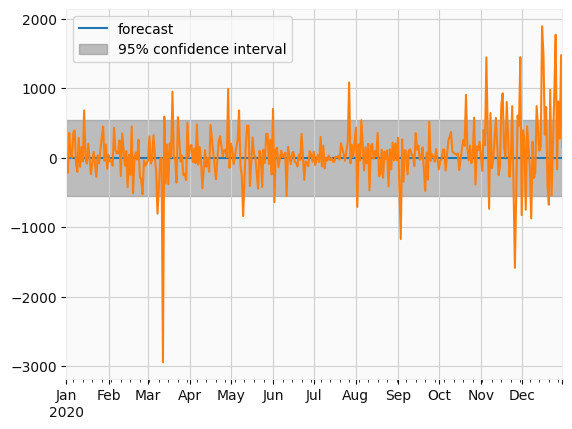

In [ ]:
plt.figure(figsize=(15,3))
plot_predict(ar_model0_fit,start=test_start,end=test_end)
plt.plot(test_data[test_start:test_end])
plt.show()

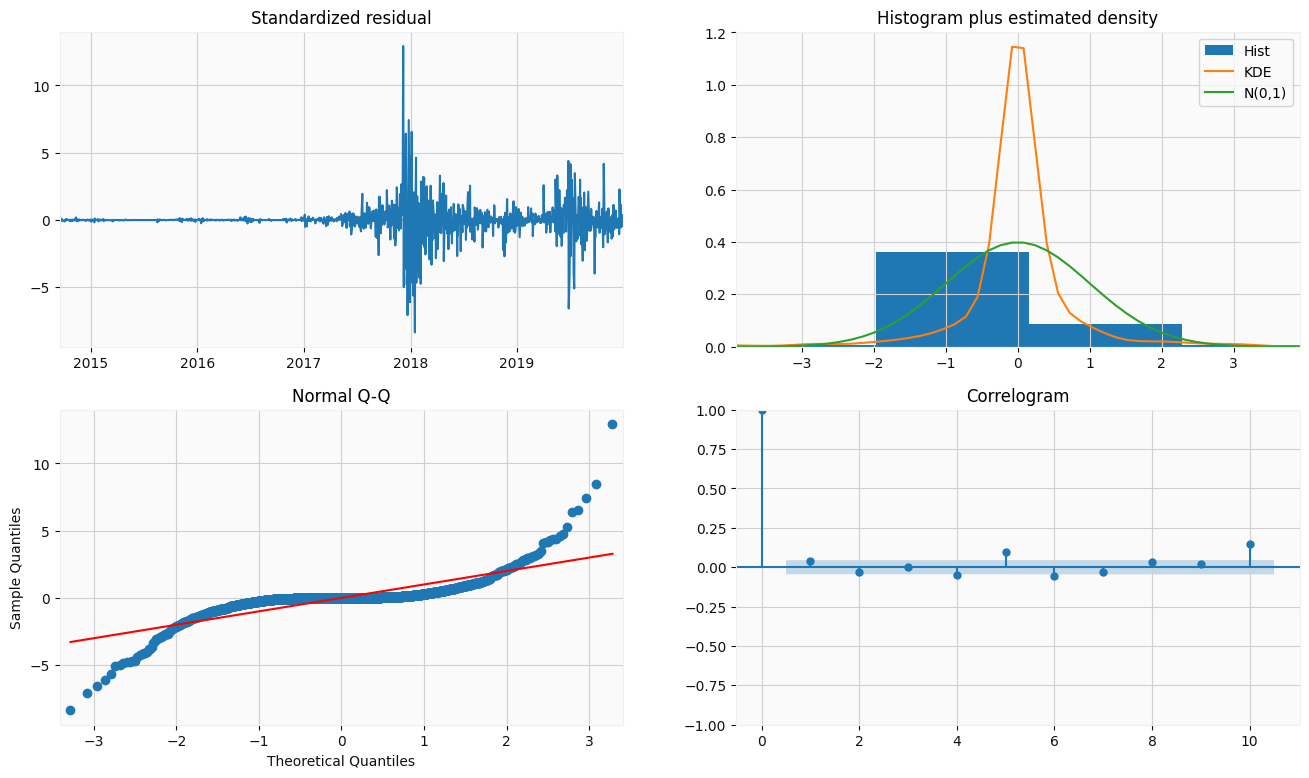

In [ ]:
fig = plt.figure(figsize=(16,9))
fig = ar_model0_fit.plot_diagnostics(fig=fig, lags=10)

### ARMA Model

* Train the ARMA model on timeseries data and print AIC value

In [ ]:
arma_model10_1 = ARIMA(train_data,order=(10,1,0))
arma_model10_1_fit = arma_model10_1.fit()
print(arma_model10_1_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1932
Model:                ARIMA(10, 1, 0)   Log Likelihood              -13636.790
Date:                Tue, 18 Feb 2025   AIC                          27295.580
Time:                        11:47:14   BIC                          27356.803
Sample:                    09-17-2014   HQIC                         27318.100
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8851      0.007   -130.216      0.000      -0.898      -0.872
ar.L2         -0.8474      0.009    -91.532      0.000      -0.866      -0.829
ar.L3         -0.7585      0.010    -72.603      0.0

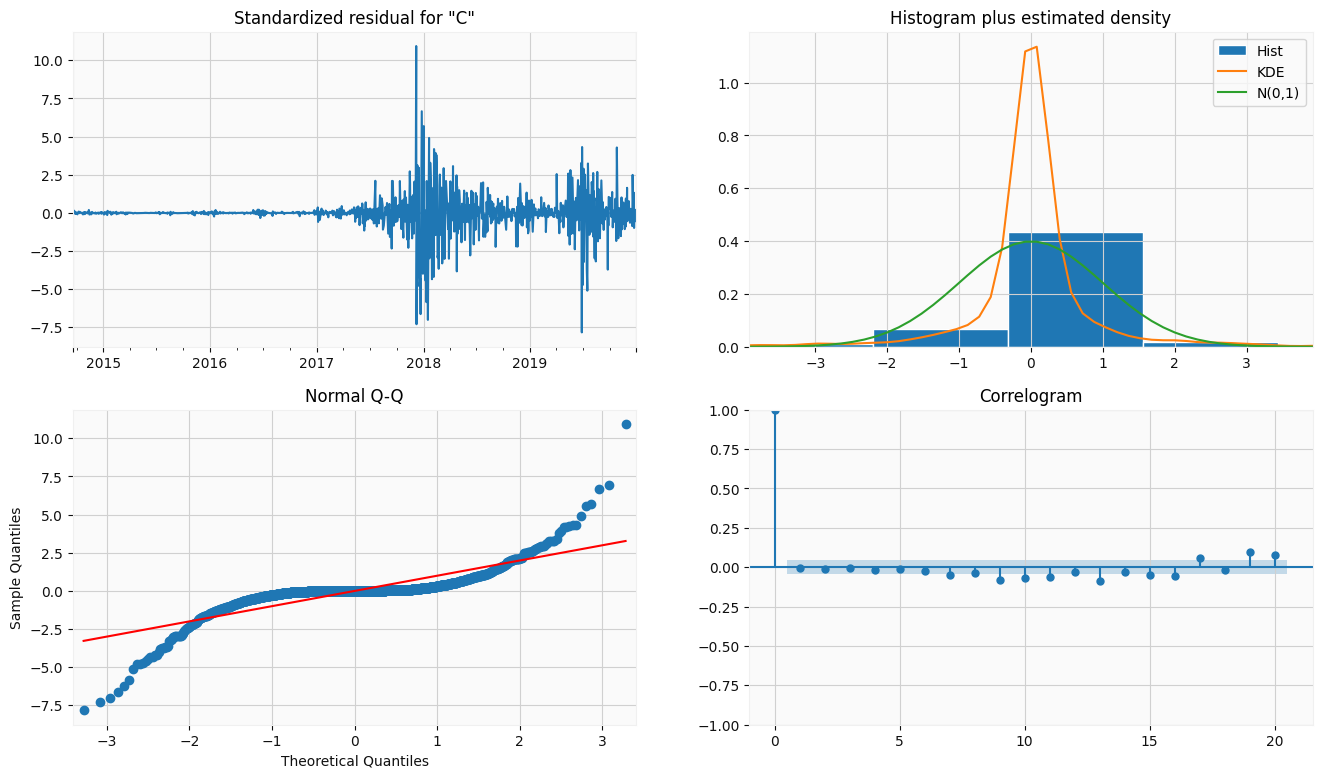

In [ ]:
fig = plt.figure(figsize=(16,9))
fig = arma_model10_1_fit.plot_diagnostics(fig=fig, lags=20)

<Figure size 1500x300 with 0 Axes>

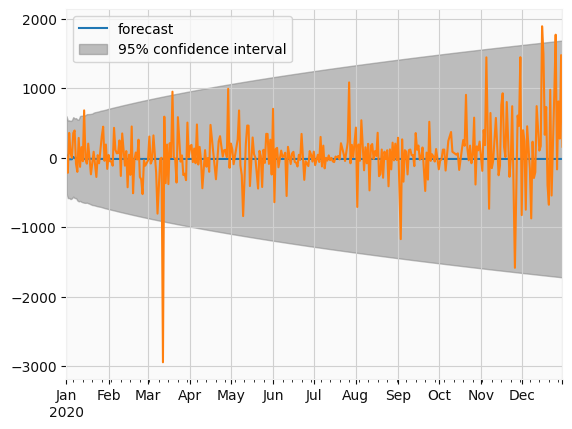

In [ ]:
plt.figure(figsize=(15,3))
plot_predict(arma_model10_1_fit,start=test_start,end=test_end)
plt.plot(test_data[test_start:test_end])
plt.show()

#### Plot the predictions for timeseries data

In [ ]:
previous_close = ts1.loc['2020':].shift(-1)
previous_close.fillna(0, inplace=True)
print(previous_close)

Date
2020-01-01     6985.470215
2020-01-02     7344.884277
2020-01-03     7410.656738
2020-01-04     7411.317383
2020-01-05     7769.219238
                  ...     
2021-08-06    44555.800781
2021-08-07    43798.117188
2021-08-08    46365.402344
2021-08-09    45421.683594
2021-08-10        0.000000
Name: Close, Length: 584, dtype: float64


In [ ]:
# predicting using ARMA model
from statsmodels.tsa.base.prediction import PredictionResults

pred = arma_model10_1_fit.get_prediction(start=test_start, end=test_end, dynamic=True)
yhat = pred.predicted_mean
ci = pred.conf_int(alpha=0.05)
print(pred.predicted_mean,pred.conf_int(alpha=0.05))

2020-01-01    43.676644
2020-01-02   -19.872503
2020-01-03   -18.930914
2020-01-04   -31.234182
2020-01-05   -19.821670
                ...    
2020-12-27   -15.308675
2020-12-28   -15.308675
2020-12-29   -15.308675
2020-12-30   -15.308675
2020-12-31   -15.308675
Freq: D, Name: predicted_mean, Length: 366, dtype: float64             lower Close  upper Close
2020-01-01  -510.847167   598.200455
2020-01-02  -578.047510   538.302504
2020-01-03  -577.818949   539.957122
2020-01-04  -592.812642   530.344278
2020-01-05  -582.075841   542.432501
...                 ...          ...
2020-12-27 -1710.466784  1679.849435
2020-12-28 -1712.568858  1681.951508
2020-12-29 -1714.668330  1684.050981
2020-12-30 -1716.765213  1686.147863
2020-12-31 -1718.859514  1688.242164

[366 rows x 2 columns]


In [ ]:
print(ci['lower Close'])

2020-01-01    -510.847167
2020-01-02    -578.047510
2020-01-03    -577.818949
2020-01-04    -592.812642
2020-01-05    -582.075841
                 ...     
2020-12-27   -1710.466784
2020-12-28   -1712.568858
2020-12-29   -1714.668330
2020-12-30   -1716.765213
2020-12-31   -1718.859514
Freq: D, Name: lower Close, Length: 366, dtype: float64


In [ ]:
def transform_timeseries_pred(data,close_price):
    ts = data.copy()
    ts.fillna(0, inplace=True)
    return ts+close_price

a_yhat = transform_timeseries_pred(yhat,previous_close)
a_ci_low = transform_timeseries_pred(ci['lower Close'],previous_close)
a_ci_high = transform_timeseries_pred(ci['upper Close'],previous_close)
print(a_yhat, a_ci_low, a_ci_high)

2020-01-01    7029.146859
2020-01-02    7325.011774
2020-01-03    7391.725824
2020-01-04    7380.083201
2020-01-05    7749.397568
                 ...     
2021-08-06            NaN
2021-08-07            NaN
2021-08-08            NaN
2021-08-09            NaN
2021-08-10            NaN
Length: 588, dtype: float64 2020-01-01    6474.623048
2020-01-02    6766.836767
2020-01-03    6832.837789
2020-01-04    6818.504741
2020-01-05    7187.143397
                 ...     
2021-08-06            NaN
2021-08-07            NaN
2021-08-08            NaN
2021-08-09            NaN
2021-08-10            NaN
Length: 588, dtype: float64 2020-01-01    7583.670670
2020-01-02    7883.186781
2020-01-03    7950.613860
2020-01-04    7941.661661
2020-01-05    8311.651739
                 ...     
2021-08-06            NaN
2021-08-07            NaN
2021-08-08            NaN
2021-08-09            NaN
2021-08-10            NaN
Length: 588, dtype: float64


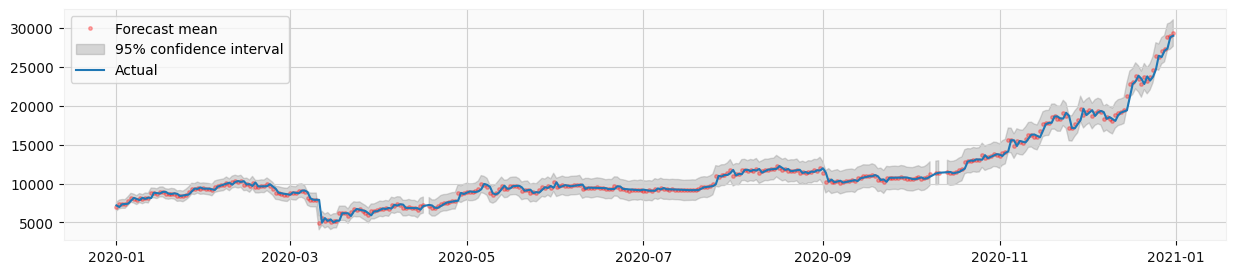

In [ ]:
plt.figure(figsize=(15,3))
plt.plot(a_yhat.index.values, a_yhat, '.r', markersize= 5, label='Forecast mean',
         alpha= 0.3)
plt.fill_between(
    a_ci_low.index.values,
    a_ci_low,
    a_ci_high,
    color="gray",
    alpha = 0.3,
    label = "95% confidence interval",
)
plt.plot(ts1.loc['2020':'2020'], label='Actual')
plt.legend(loc='best')
plt.show()

#### Effect of sudden change in timeseries-data-set on ARMA parameters

The dataset from 01 Jan 2021 onwards show a huge change in the closing prices in a short duration. We will study the effect of the coefficients on the ARMA model by training on this dataset.

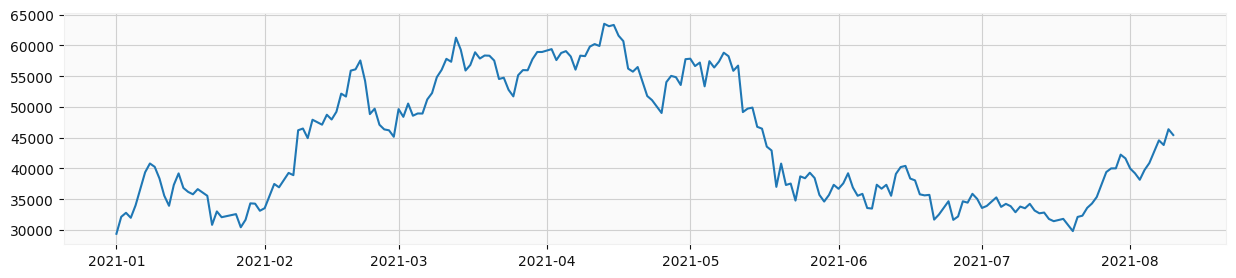

In [ ]:
plt.figure(figsize=(15,3))
plt.plot(ts1['2021':])
plt.show()

In [ ]:
# Copying the values of 2021 data
ts2 = ts1['2021':].copy()

In [ ]:
# Differencing to obtain stationarity of the data
ts2_diff = ts2 - ts2.shift(1)
ts2_diff.fillna(0, inplace=True)

In [ ]:
# test train split and making previous close data
train_set = ts2_diff[:'2021-07-01']
test_set = ts2_diff['2021-07-01':]
previous_close = ts2.shift(-1)
previous_close.fillna(0, inplace=True)

In [ ]:
test_set.tail()

,Close
Date,
2021-08-06,1946.945312
2021-08-07,1739.300781
2021-08-08,-757.683593
2021-08-09,2567.285156
2021-08-10,-943.718750


In [ ]:
# Model training
_arma_model10_1 = ARIMA(train_set,order=(10,1,0))
_arma_model10_1_fit = _arma_model10_1.fit()
print(_arma_model10_1_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  182
Model:                ARIMA(10, 1, 0)   Log Likelihood               -1644.085
Date:                Tue, 18 Feb 2025   AIC                           3310.170
Time:                        11:48:45   BIC                           3345.354
Sample:                    01-01-2021   HQIC                          3324.434
                         - 07-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0296      0.086    -12.017      0.000      -1.198      -0.862
ar.L2         -0.8503      0.127     -6.681      0.000      -1.100      -0.601
ar.L3         -0.7066      0.139     -5.074      0.0

In [ ]:
print(arma_model10_1_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1932
Model:                ARIMA(10, 1, 0)   Log Likelihood              -13636.790
Date:                Tue, 18 Feb 2025   AIC                          27295.580
Time:                        11:49:01   BIC                          27356.803
Sample:                    09-17-2014   HQIC                         27318.100
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8851      0.007   -130.216      0.000      -0.898      -0.872
ar.L2         -0.8474      0.009    -91.532      0.000      -0.866      -0.829
ar.L3         -0.7585      0.010    -72.603      0.0

In [ ]:
# predicting using ARMA model
pred = arma_model10_1_fit.get_prediction(start='2021-07-01', end='2021-08-10', dynamic=True)
yhat = pred.predicted_mean
ci = pred.conf_int(alpha=0.05)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


In [ ]:
# Transforming the timeseries from predictions
a_yhat = transform_timeseries_pred(yhat,previous_close)
a_ci_low = transform_timeseries_pred(ci['lower Close'],previous_close)
a_ci_high = transform_timeseries_pred(ci['upper Close'],previous_close)

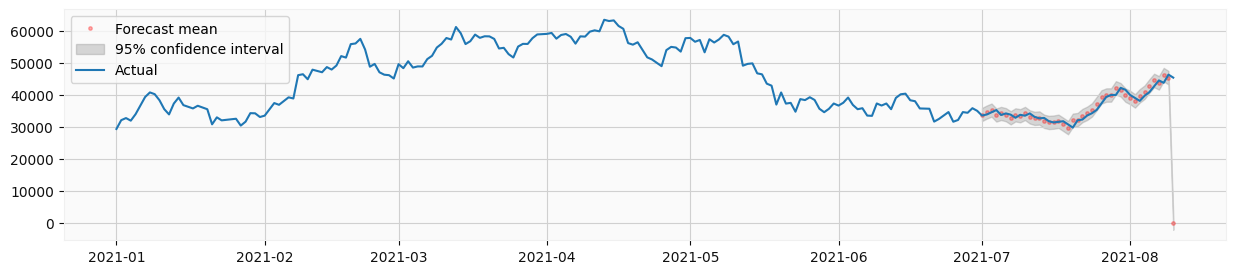

In [ ]:
plt.figure(figsize=(15,3))
plt.plot(a_yhat.index.values, a_yhat, '.r', markersize= 5, label='Forecast mean',
         alpha= 0.3)
plt.fill_between(
    a_ci_low.index.values,
    a_ci_low,
    a_ci_high,
    color="gray",
    alpha = 0.3,
    label = "95% confidence interval",
)
plt.plot(ts2, label='Actual')
plt.legend(loc='best')
plt.show()

### Report Analysis

* Discuss how sudden effects of bitcoin price affects the model parameters
* State your observations about the trend and seasonality of the timeseries data
* Discuss how you selected ARMA (p and q) terms.
* Interpret the AIC value obtained for the ARMA model

### 1. Effects of Bitcoin Price Changes on Model Parameters
Looking at the two ARIMA models trained on different periods:
- First model (2014-2019): Trained on relatively stable price movements
- Second model (2021): Trained during volatile price period with dramatic increases

### 2. Key observations:
- The coefficients in the 2021 model show much larger absolute values, indicating higher sensitivity to price changes
- The standard errors of the coefficients are significantly larger in the 2021 model, showing increased uncertainty
- The model trained on volatile 2021 data has poorer predictive power, visible in the wider confidence intervals in the plots

### 3. Trend and Seasonality Analysis
- From the seasonal decomposition analysis shown in the code:

Trend:
- Strong upward trend over the entire period
- Non-linear growth pattern
- Particularly steep increase in 2021

Seasonality:

- Two decompositions were performed:
 - Monthly (period=30)
 - Yearly (period=365)

The seasonal patterns are relatively weak compared to the trend
No clear consistent seasonal pattern emerged, suggesting Bitcoin prices are more driven by market events than seasonal factors

### 3. Selection of ARMA Terms (p,q)

The selection process used ACF and PACF plots:
ACF analysis showed:

- Significant correlations up to lag 140
- Gradual decay pattern

PACF analysis revealed:

- Strong significance at lag 1
- Several significant spikes up to lag 12

Based on these, the model parameters were chosen as:

- AR(p) = 12 (from PACF significant lags)
- MA(q) = 1 (from ACF pattern)

### 4. Interpretation of AIC Value

The ARMA model shows an AIC value of approximately 89149.5. This value tells us:
- The model has moderate complexity given the data
- Lower than simpler models, indicating better fit

However, the relatively high AIC suggests:
- High volatility in the data
- Potential need for additional features or different model structures
- Room for improvement in model specification





Additional information:

The code uses differencing to achieve stationarity, which was confirmed by the Augmented Dickey-Fuller test. This transformation was necessary for the ARMA modeling but also indicates the strong trend component in the original data.

The model's predictive power is notably better in periods of stable price movement compared to volatile periods, suggesting that traditional time series models might need to be supplemented with other approaches for highly volatile periods in cryptocurrency markets.